In [ ]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Core libraries for data manipulation
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation

# Visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For advanced visualizations

# Machine learning models
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Decision Tree model & visualization
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors model
from sklearn.svm import SVC  # Support Vector Machine model

# Preprocessing & Pipelines
from sklearn.preprocessing import MinMaxScaler, LabelEncoder  # Scaling & Encoding
from sklearn.pipeline import Pipeline  # For combining steps in SVM/KNN

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score,  # Overall accuracy
    confusion_matrix,  # Confusion matrix
    classification_report,  # Precision, Recall, F1-score summary
    f1_score, recall_score, roc_auc_score,  # Key classification metrics
    roc_curve, precision_recall_curve,  # Evaluation curves
)

# Visualization tools for evaluation
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay  # Display confusion & PR curves

# **Data Loading**

In [ ]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

train_data = pd.read_csv(train_url, header=None)
test_data = pd.read_csv(test_url, skiprows=1, header=None)

columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
           'native-country', 'income']
train_data.columns = columns
test_data.columns = columns

# **Exploratory data analysis**

In [ ]:
numerical_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

## Class Imbalance:
- The income classes are imbalanced, with the majority class (`<=50K`) being 76% of the data.
- This imbalance may affect model training and evaluation.

## Duplicate Rows:
- 24 duplicate rows were identified in the dataset. These will be removed during preprocessing.

## Missing Values:
- Columns with missing values:
  - `workclass`: 1836 missing values.
  - `occupation`: 1843 missing values.
  - `native-country`: 583 missing values.
- These missing values will be removed during preprocessing.


In [ ]:
# Check for class imbalance in the target variable
print("Class distribution in income:")
print(train_data['income'].value_counts())

# Check for duplicate rows
print("\nNumber of duplicate rows:", train_data.duplicated().sum())

# Check for missing values (represented by '?')
print("\nMissing values per column:")
print(train_data.replace(r'\?', pd.NA, regex=True).isnull().sum())

Class distribution in income:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Number of duplicate rows: 24

Missing values per column:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


## After running the below cell, some attributes like capital-gain and capital-loss have significant outliers.
## These could impact the performance of certain models, but decision trees are relatively resilient to outliers.

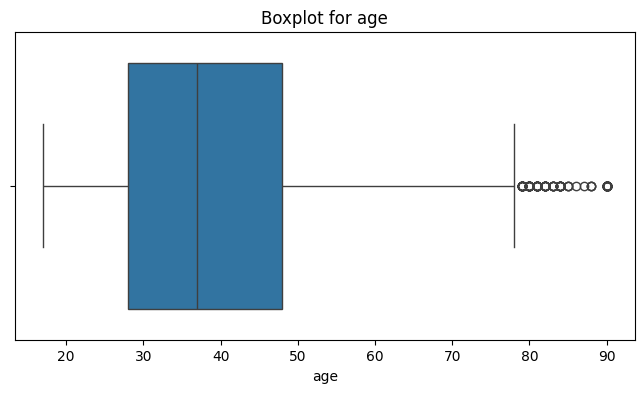

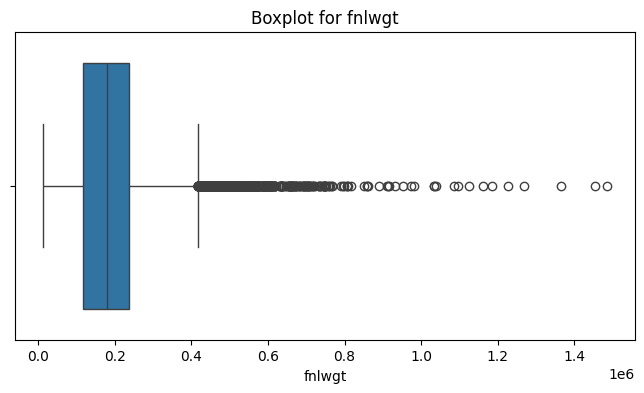

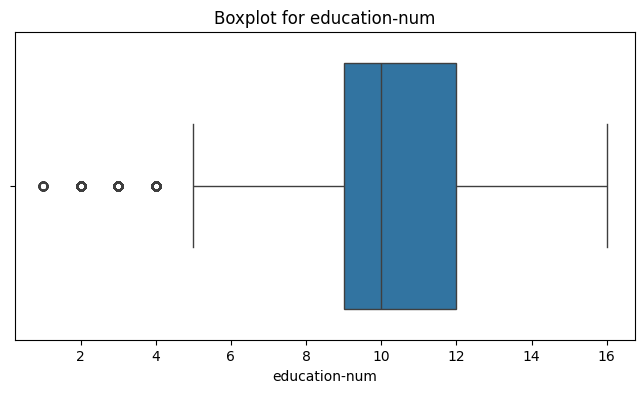

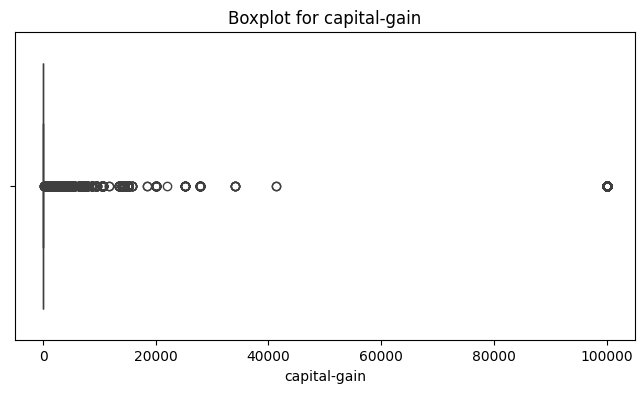

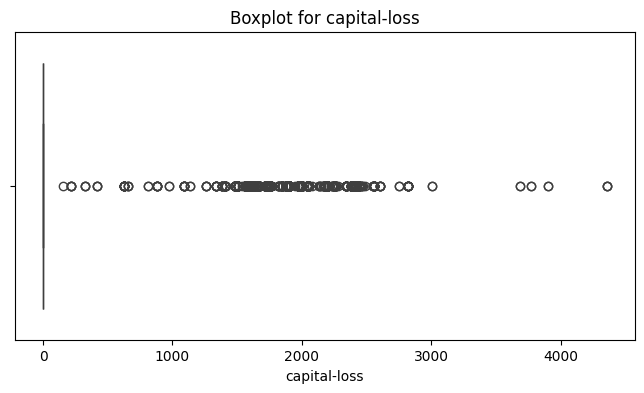

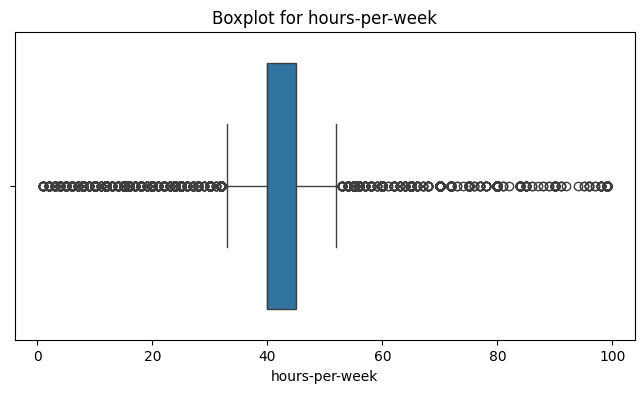

In [ ]:
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_data[feature])
    plt.title(f"Boxplot for {feature}")
    plt.show()

## The pairplot below visualizes pairwise relationships between numerical features, color-coded by income class.This helps identify which features might be more informative for classification.

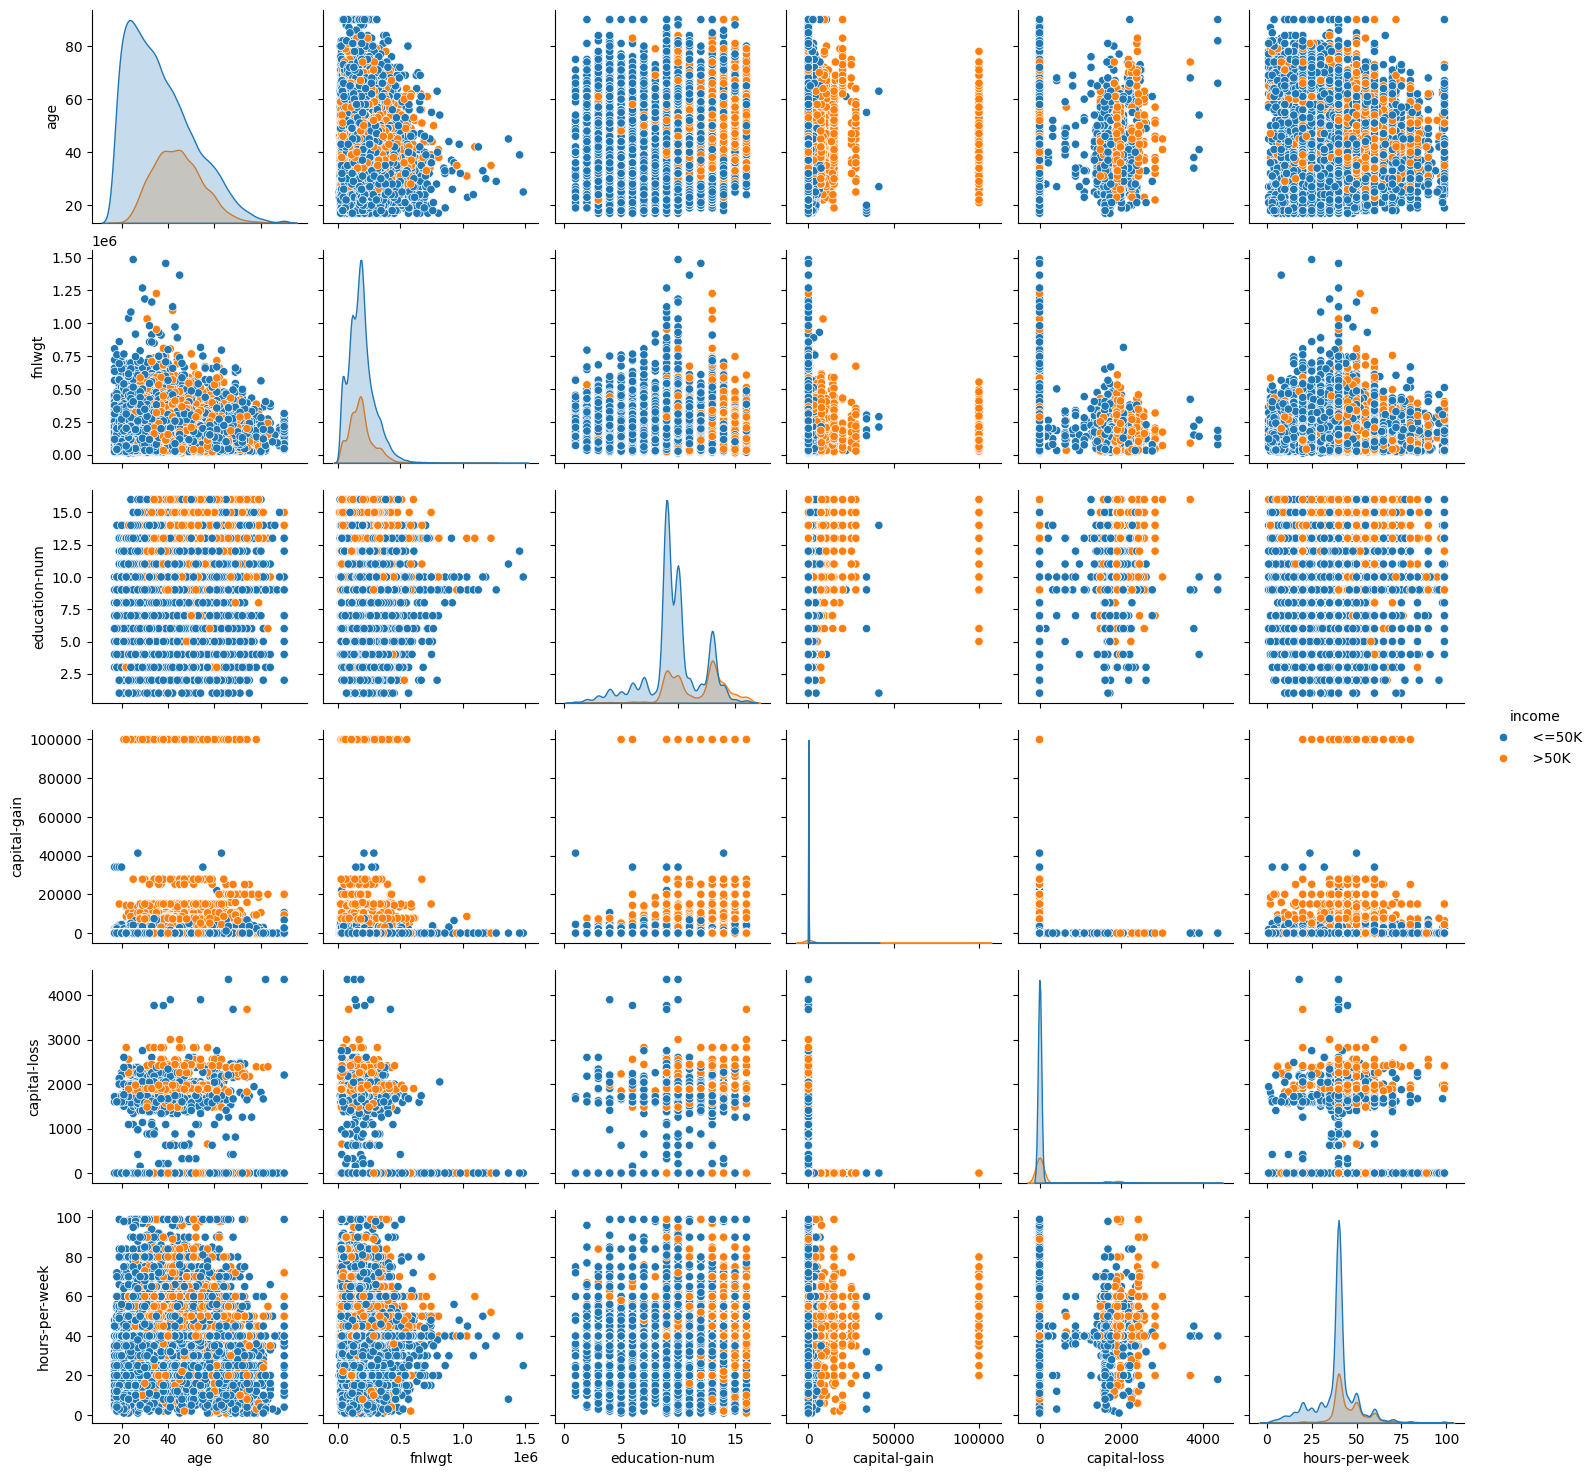

In [ ]:
sns.pairplot(train_data[numerical_features + ['income']], hue='income')

# **Preprocessing**

In [ ]:
# Replace '?' with NaN
train_data = train_data.replace(r'\?', pd.NA, regex=True)
test_data = test_data.replace(r'\?', pd.NA, regex=True)

dropped_train_na = len(train_data) - len(train_data.dropna())
dropped_test_na = len(test_data) - len(test_data.dropna())
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

dropped_train_dup = len(train_data) - len(train_data.drop_duplicates())
dropped_test_dup = len(test_data) - len(test_data.drop_duplicates())
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

print(f"Invalid rows dropped from train data (missing values): {dropped_train_na}")
print(f"Invalid rows dropped from test data (missing values): {dropped_test_na}")
print(f"Duplicate rows dropped from train data: {dropped_train_dup}")
print(f"Duplicate rows dropped from test data: {dropped_test_dup}")


Invalid rows dropped from train data (missing values): 2399
Invalid rows dropped from test data (missing values): 1221
Duplicate rows dropped from train data: 23
Duplicate rows dropped from test data: 5


In [ ]:
print(f"Class labels in train data: {train_data['income'].unique()}")
print(f"Class labels in test data: {test_data['income'].unique()}") # Different class labels!

Class labels in train data: [' <=50K' ' >50K']
Class labels in test data: [' <=50K.' ' >50K.']


In [ ]:
X_train = train_data.drop('income', axis=1)
y_train = train_data['income']
X_test = test_data.drop('income', axis=1)
y_test = test_data['income']
y_test = y_test.str.strip('.') # Remove the mistakenly added period in the class labels of the given test data

In [ ]:
# Select categorical columns for encoding
categorical_features = X_train.select_dtypes(include=['object']).columns

# Fit the LabelEncoder on the training data for each categorical column
le = LabelEncoder()

for col in categorical_features:
    print(f"Fitting LabelEncoder on column '{col}'...")
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

Fitting LabelEncoder on column 'workclass'...
Fitting LabelEncoder on column 'education'...
Fitting LabelEncoder on column 'marital-status'...
Fitting LabelEncoder on column 'occupation'...
Fitting LabelEncoder on column 'relationship'...
Fitting LabelEncoder on column 'race'...
Fitting LabelEncoder on column 'sex'...
Fitting LabelEncoder on column 'native-country'...


In [ ]:
# Count the number of rows in the training data
train_count = len(train_data)

# Count the number of rows in the testing data
test_count = len(test_data)

# Calculate the total number of data points
total_count = train_count + test_count

print(f"Number of training samples: {train_count}")
print(f"Number of testing samples: {test_count}")
print(f"Total number of samples: {total_count}")

Number of training samples: 30139
Number of testing samples: 15055
Total number of samples: 45194


In [ ]:
model = DecisionTreeClassifier(
    criterion='entropy', # Use entropy as the splitting criterion (information gain)
    max_depth=8, # Limit the maximum depth of the tree to 8 levels
    min_samples_leaf=5, # Require at least 5 samples in a leaf node
    min_samples_split=10, # Require at least 10 samples to split an internal node
)

model.fit(X_train, y_train) # Train the model

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5,
                       min_samples_split=10)

# Model Evaluation: F1 Score and Accuracy

In this section, we evaluate the performance of the Decision Tree model using two key metrics:

- **F1 Score**: This metric considers both precision and recall to provide a balanced measure of a model's accuracy, especially when dealing with imbalanced datasets.
  - **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
  - **Recall**: The ratio of correctly predicted positive observations to the total actual positives.

- **Accuracy**: The percentage of correctly predicted observations out of all observations in the dataset.

The code below calculates and prints the **F1 Score** and **Accuracy** for the test dataset to assess the model's performance.

In [ ]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.8397527927732512
Accuracy: 0.8508136831617403


## Decision Tree Visualization

This section displays the visualization of the Decision Tree trained on the dataset.

- The **nodes** represent the decisions made at each step based on the features.
- The **splits** are determined by the model to best classify the data into the target classes (`<=50K` and `>50K`).
- **Feature Names**: Display the features used for each decision split.
- **Class Names**: Indicate the class predictions at the terminal nodes.
- **Filled Nodes**: Nodes are color-coded to represent the majority class in that node.

Below is the Decision Tree limited to a depth of 3 for better readability.


[Text(0.5431034482758621, 0.9, 'relationship <= 0.5\n30139\n[22633, 7506]\n<=50K'),
 Text(0.27586206896551724, 0.7, 'education-num <= 12.5\n12457\n[6780, 5677]\n<=50K'),
 Text(0.40948275862068967, 0.8, 'True  '),
 Text(0.13793103448275862, 0.5, 'capital-gain <= 5095.5\n8727\n[5788, 2939]\n<=50K'),
 Text(0.06896551724137931, 0.3, 'education-num <= 7.5\n8285\n[5781, 2504]\n<=50K'),
 Text(0.034482758620689655, 0.1, '\n  (...)  \n'),
 Text(0.10344827586206896, 0.1, '\n  (...)  \n'),
 Text(0.20689655172413793, 0.3, 'age <= 61.5\n442\n[7, 435]\n>50K'),
 Text(0.1724137931034483, 0.1, '\n  (...)  \n'),
 Text(0.2413793103448276, 0.1, '\n  (...)  \n'),
 Text(0.41379310344827586, 0.5, 'capital-gain <= 5095.5\n3730\n[992, 2738]\n>50K'),
 Text(0.3448275862068966, 0.3, 'capital-loss <= 1782.5\n3151\n[990.0, 2161.0]\n>50K'),
 Text(0.3103448275862069, 0.1, '\n  (...)  \n'),
 Text(0.3793103448275862, 0.1, '\n  (...)  \n'),
 Text(0.4827586206896552, 0.3, 'age <= 62.5\n579\n[2, 577]\n>50K'),
 Text(0.4482

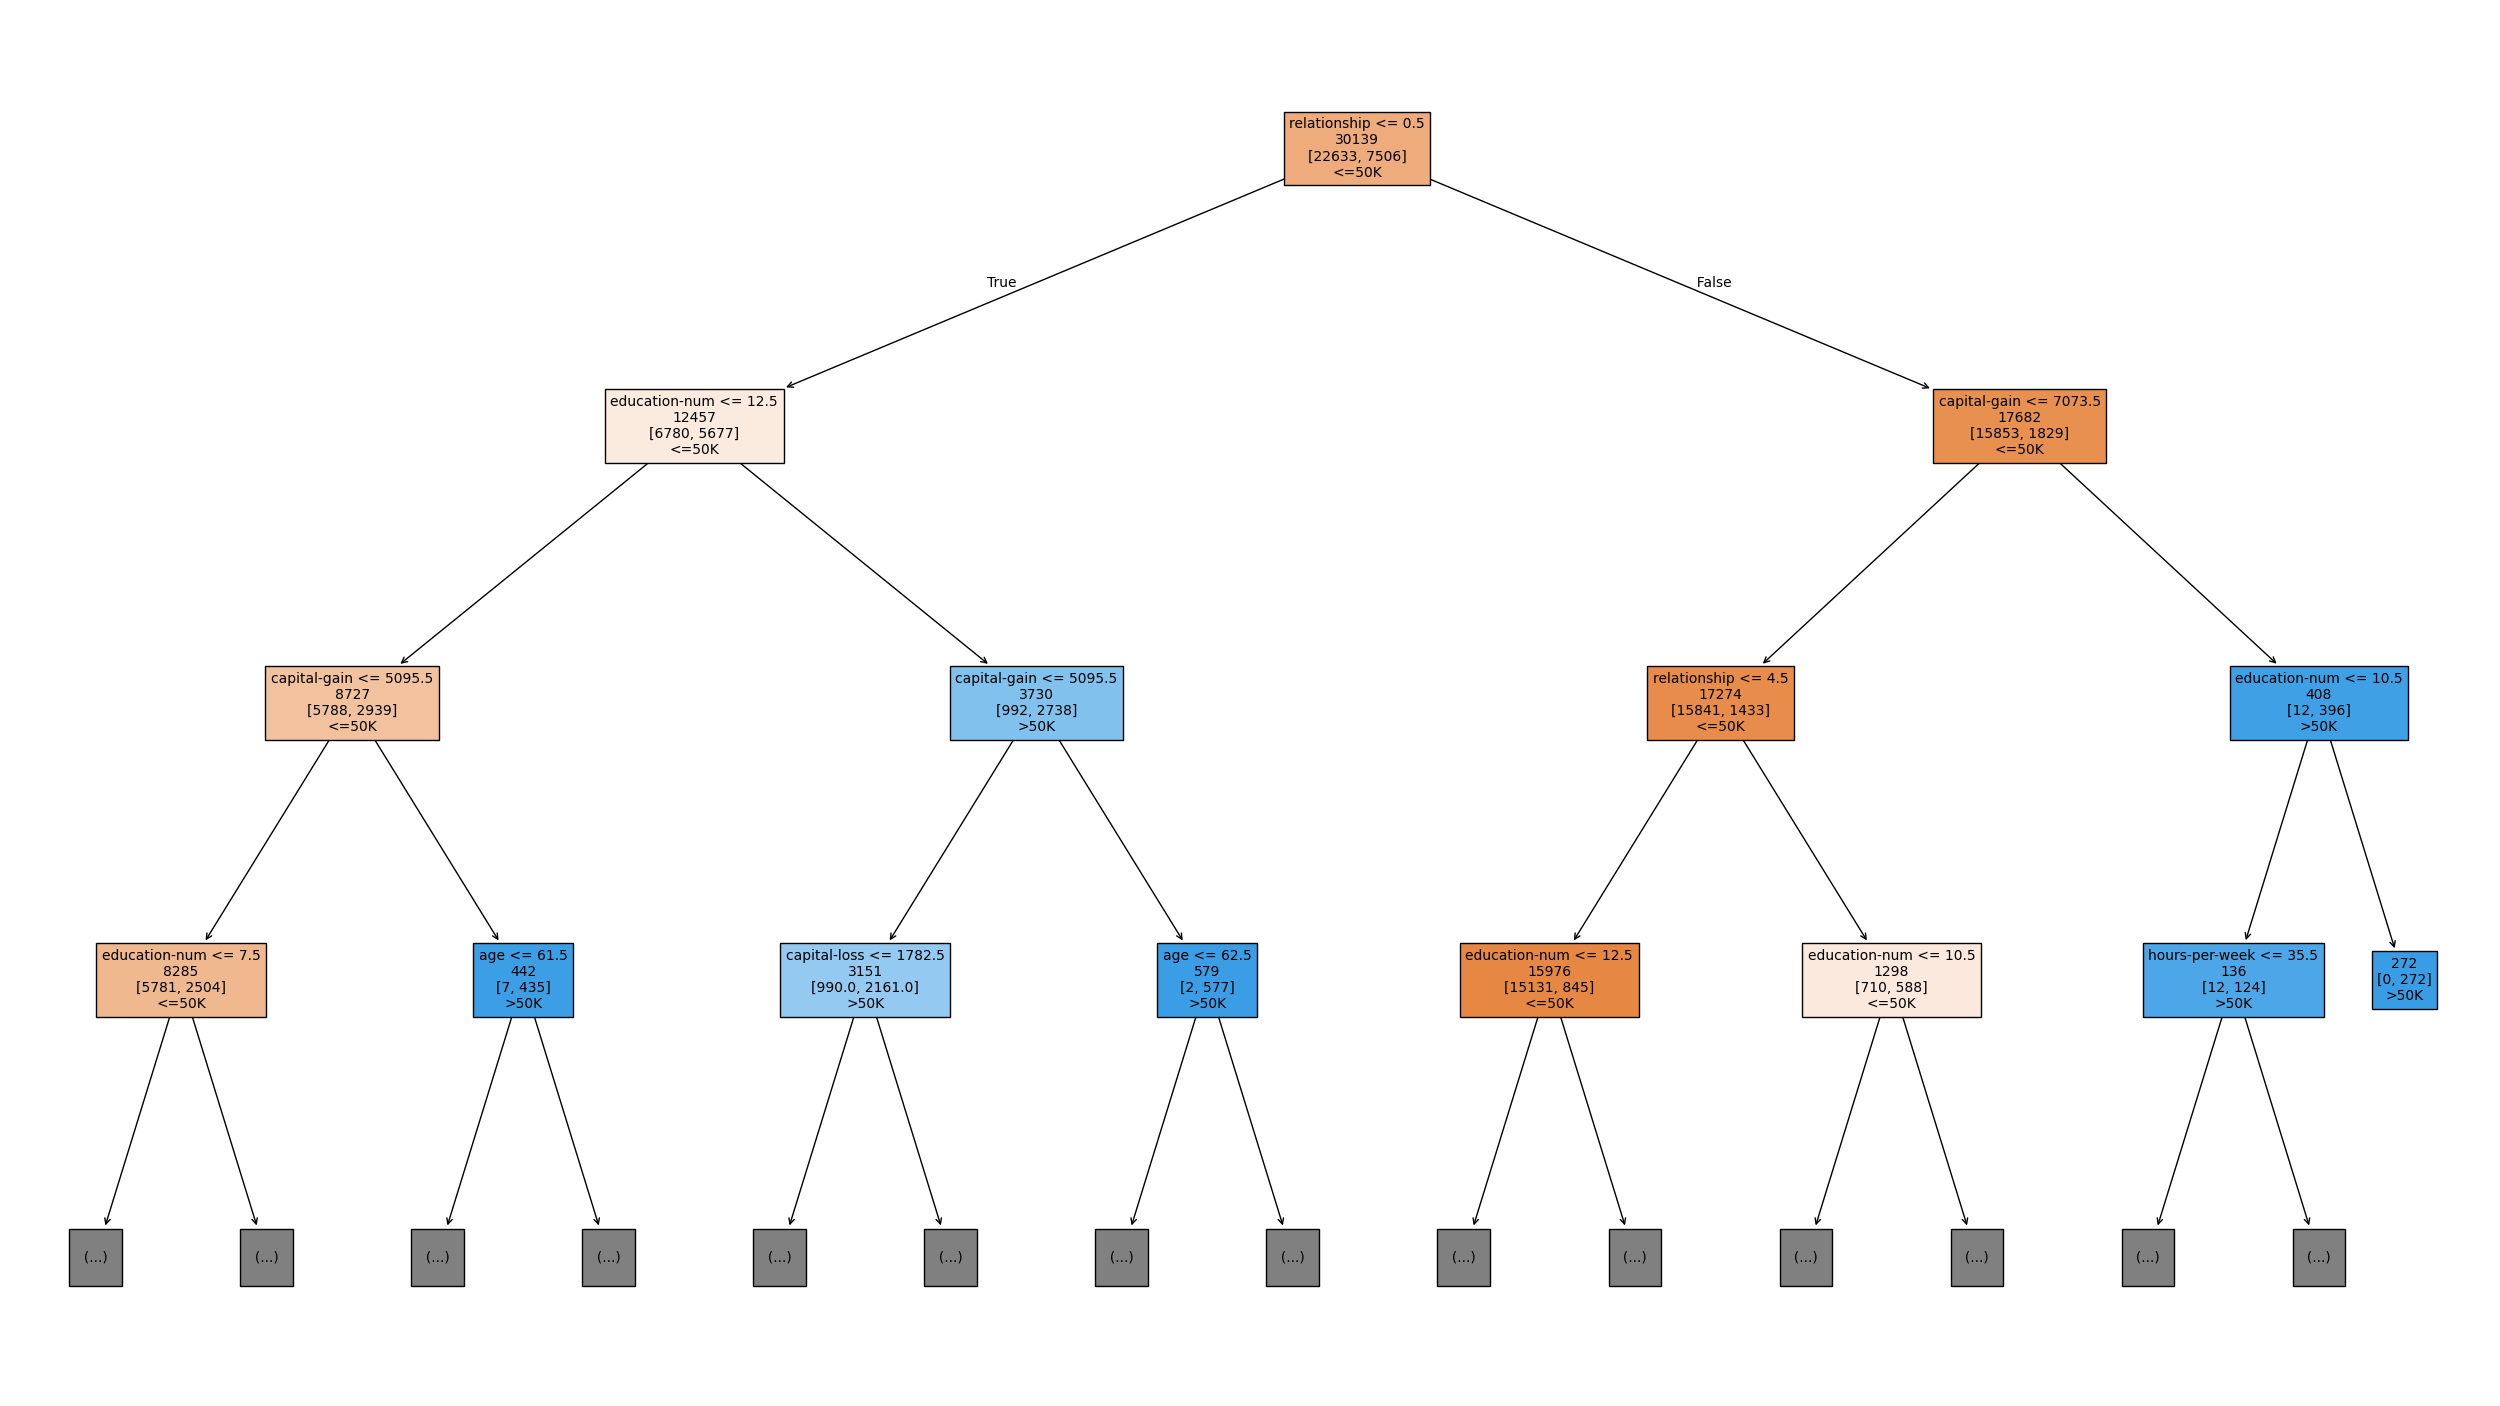

In [ ]:
plt.figure(figsize=(32, 18))
plot_tree(model, feature_names=X_train.columns, class_names=['<=50K', '>50K'], filled=True, max_depth=3, fontsize=10, impurity=False, label='none')

The Confusion Matrix is used to evaluate the performance of the Decision Tree model. It provides a summary of the prediction results by comparing the actual labels with the predicted labels.

- **True Positive (TP):** The model correctly predicts a positive class.
- **True Negative (TN):** The model correctly predicts a negative class.
- **False Positive (FP):** The model incorrectly predicts a positive class (Type I error).
- **False Negative (FN):** The model incorrectly predicts a negative class (Type II error).

Below is the Confusion Matrix for the test dataset, along with the total number of correct and incorrect predictions.

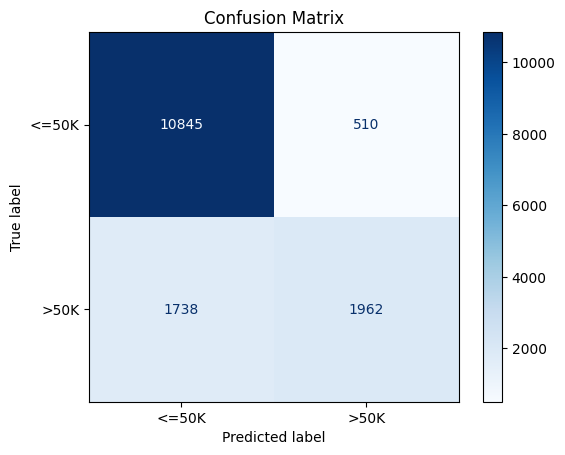

In [ ]:
# Calculate predictions
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## The below Feature Importance plot highlights which features contributed most to the classification decisions.

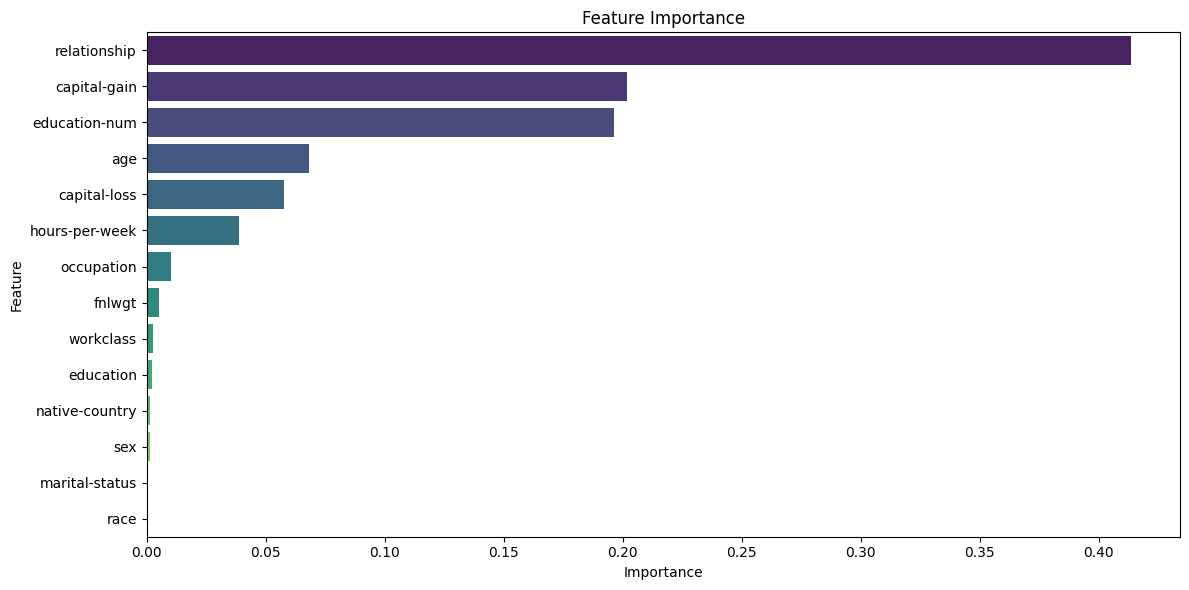

In [ ]:
# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance")
plt.tight_layout()



#Sets up a Support Vector Machine (SVM) model using a pipeline.

## The pipeline consists of two steps:
## 1. Scaling the features using MinMaxScaler to normalize the data.
## 2. Training an SVM classifier with SVC (Support Vector Classification).
## The model is then fitted on the training data (X_train, y_train).
## After fitting, the model is used to make predictions on the test data (X_test).
## The predictions are stored in y_pred.


In [ ]:
# Define hyperparameter grid
svm_param_grid = {
    "SVC__C": [0.1, 1, 10],  # Regularization parameter
    "SVC__kernel": ["linear", "rbf"]  # Kernel function
}

# Initialize pipeline
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Normalize input data
    ('SVC', SVC(probability=True))
])

# Perform GridSearch with 2-fold cross-validation
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=2, scoring='accuracy')
svm_grid.fit(X_train, y_train)

# Train final SVM model with best parameters
svm_best = svm_grid.best_estimator_

# Prediction
y_pred = svm_best.predict(X_test)

# defines a function to evaluate the performance of a classification model.
## The function takes the following inputs:
## - model: The trained model to evaluate.
## - X_train, y_train: The training data and labels.
## - X_test, y_test: The test data and labels.
## - i: A string identifier for the model (e.g., 'svm_model').

## The function performs the following steps:
## 1. Makes predictions on both the training and test sets.
## 2. Prints the confusion matrix and classification report for the test set.
## 3. Prints the confusion matrix and classification report for the training set.

## The function is then called with the SVM model (svm_model) to evaluate its performance.

In [ ]:
# Evaluating the Model Performance using Classification Metrics

def eval_metric(model, X_train, y_train, X_test, y_test, i):
    """
    Evaluates a given model's performance using:
    - Confusion Matrix
    - Classification Report (Precision, Recall, F1-score)
    """

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print(f"{i} Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print(f"{i} Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# eval_metric(svm_best, X_train, y_train, X_test, y_test, 'Tuned SVM')

 # evaluates the SVM model's performance using additional metrics and visualizations:
## 1. Predicted Probabilities: The model's predicted probabilities for the test set are obtained using `predict_proba`.
## 2. ROC-AUC Score: The ROC-AUC score is calculated to measure the model's ability to distinguish between classes.
## 3. Confusion Matrix: A normalized confusion matrix is displayed to visualize the model's performance in terms of true positives, false positives, true negatives, and false negatives.
## 4. Precision-Recall Curve: A Precision-Recall curve is plotted to show the trade-off between precision and recall for different thresholds.##

SVM model ROC_AUC Score: 0.8907680269437206
--------------------------------------------------


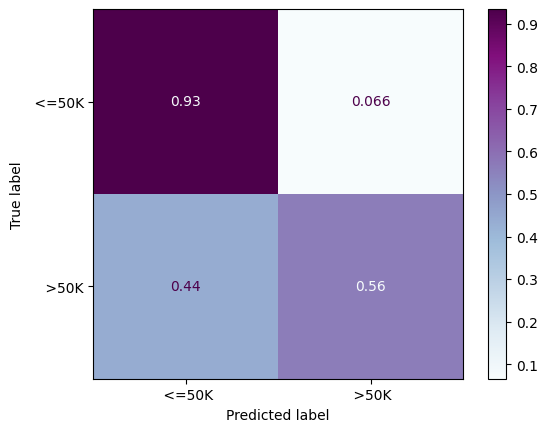

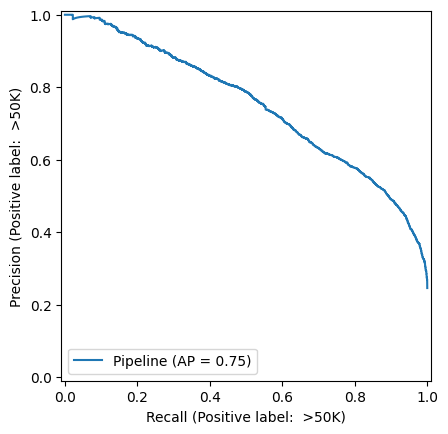

In [ ]:
# Get predicted probabilities for the test set
y_pred_proba = svm_best.predict_proba(X_test)

# Roc_AUC_score
print('SVM model ROC_AUC Score:', roc_auc_score(y_test, y_pred_proba[:, 1]))
print('--------------------------------------------------')

# Confusion Matrix
svm_matrix = ConfusionMatrixDisplay.from_estimator(svm_best, X_test, y_test, normalize='true', cmap='BuPu')

# Precision-Recall Curve
svm_prCurve = PrecisionRecallDisplay.from_estimator(svm_best, X_test, y_test)


# Sets up a K-Nearest Neighbors (KNN) model using a pipeline.
## The pipeline consists of two steps:
## 1. Scaling the features using MinMaxScaler to normalize the data.
## 2. Training a KNN classifier with KNeighborsClassifier.
## The model is then fitted on the training data (X_train, y_train).

In [ ]:
# Define hyperparameter grid
knn_param_grid = {
    "knn__n_neighbors": [3, 5],  # Number of neighbors
    "knn__weights": ["uniform", "distance"]  # Weight function
}

# Initialize pipeline
knn_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", KNeighborsClassifier())
])

# Perform GridSearch with 2-fold cross-validation
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=2, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Train final KNN model with best parameters
knn_best = knn_grid.best_estimator_

# performs the following steps for the KNN model:
## 1. Encodes the target variables (y_test) into numeric values using LabelEncoder.
## 2. Makes predictions on the test set (X_test) using the trained KNN model.
## 3. Encodes the predicted labels (y_pred) to ensure they match the encoded format of y_test.
## 4. Computes predicted probabilities for the test set using `predict_proba`.
## 5. Calculates evaluation metrics:
##    - F1 Score: A measure of the model's accuracy, balancing precision and recall.
##    - Recall: The ability of the model to correctly identify positive instances.
##    - ROC-AUC Score: The area under the ROC curve, measuring the model's ability to distinguish between classes.
## These scores are stored for later comparison with other models.

In [ ]:
# Encode target variables to numeric
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# Prediction and probabilities for the KNN model
y_pred = knn_best.predict(X_test)
y_pred_encoded = le.fit_transform(y_pred)  # Ensure predictions are encoded
y_pred_proba = knn_best.predict_proba(X_test)

# Scores to compare the models at the end
knn_f1 = f1_score(y_test_encoded, y_pred_encoded)
knn_recall = recall_score(y_test_encoded, y_pred_encoded)
knn_auc = roc_auc_score(y_test_encoded, y_pred_proba[:, 1])

In [ ]:
# Evaluating the Model Performance using Classification Metrics

eval_metric(knn_best, X_train, y_train, X_test, y_test, 'Tuned KNN')

Tuned KNN Test_Set
[[10212  1143]
 [ 1589  2111]]
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.88     11355
        >50K       0.65      0.57      0.61      3700

    accuracy                           0.82     15055
   macro avg       0.76      0.73      0.74     15055
weighted avg       0.81      0.82      0.81     15055


Tuned KNN Train_Set
[[21116  1517]
 [ 2348  5158]]
              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.92     22633
        >50K       0.77      0.69      0.73      7506

    accuracy                           0.87     30139
   macro avg       0.84      0.81      0.82     30139
weighted avg       0.87      0.87      0.87     30139



# evaluates the KNN model's performance using additional metrics and visualizations:
## 1. ROC-AUC Score: The ROC-AUC score is calculated to measure the model's ability to distinguish between classes using the predicted probabilities.
## 2. Confusion Matrix: A normalized confusion matrix is displayed to visualize the model's performance in terms of true positives, false positives, true negatives, and false negatives.
## 3. Precision-Recall Curve: A Precision-Recall curve is plotted to show the trade-off between precision and recall for different thresholds.

KNN model ROC_AUC Score: 0.8390471991145704
--------------------------------------------------


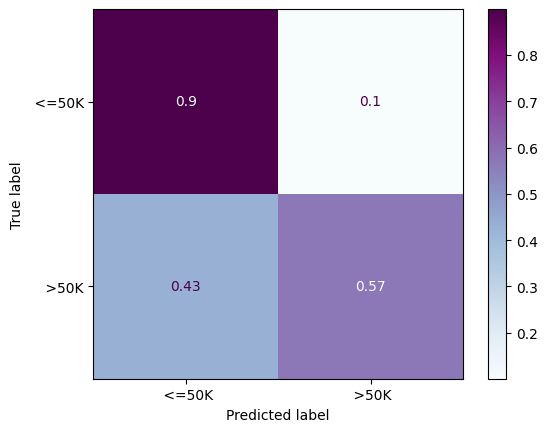

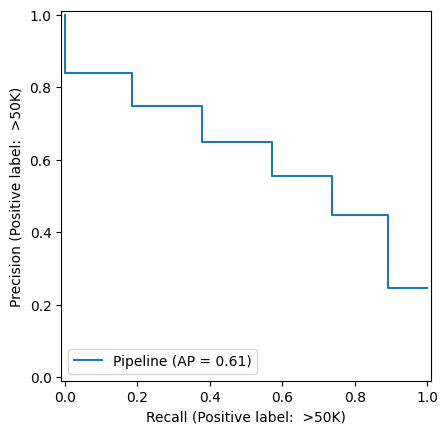

In [ ]:
# Roc_AUC_score
print('KNN model ROC_AUC Score:', roc_auc_score(y_test, y_pred_proba[:,1]))
print('--------------------------------------------------')

# Confusion Matrix
knn_matrix = ConfusionMatrixDisplay.from_estimator(knn_best, X_test,y_test, normalize='true', cmap='BuPu' )

# Precision-Recall Curve
knn_prCurve = PrecisionRecallDisplay.from_estimator(knn_best, X_test, y_test)

# Comparing the All Models (Decision-SVM-KNN)

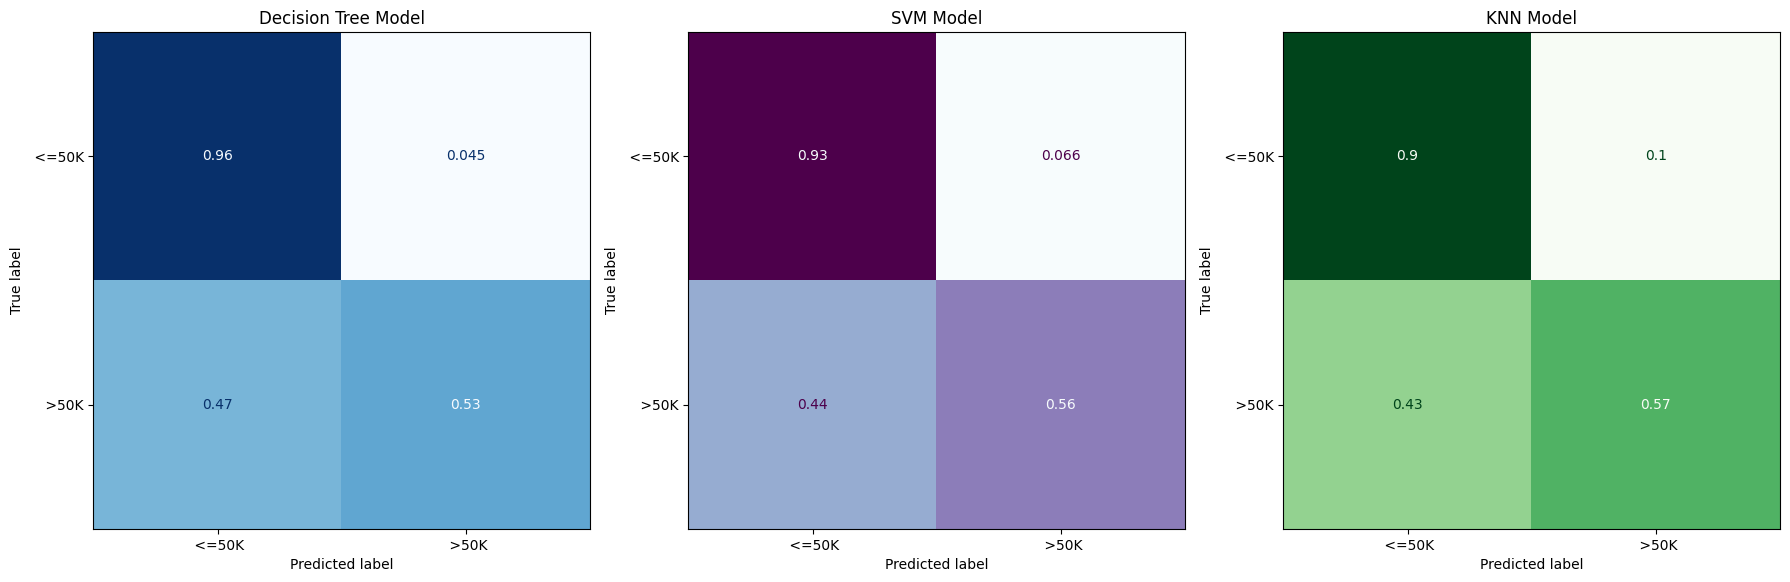

In [ ]:
# Confusion Matrix for all models
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a subplot with 3 axes

# Decision Tree
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, normalize='true', cmap='Blues', ax=ax[0], colorbar=False
)  # Replace 'model' with your Decision Tree model variable
ax[0].set_title("Decision Tree Model")

# SVM
ConfusionMatrixDisplay.from_estimator(
    svm_best, X_test, y_test, normalize='true', cmap='BuPu', ax=ax[1], colorbar=False
)
ax[1].set_title("SVM Model")

# KNN
ConfusionMatrixDisplay.from_estimator(
    knn_best, X_test, y_test, normalize='true', cmap='Greens', ax=ax[2], colorbar=False
)
ax[2].set_title("KNN Model")

# Adjust layout and display
plt.tight_layout()
plt.show()


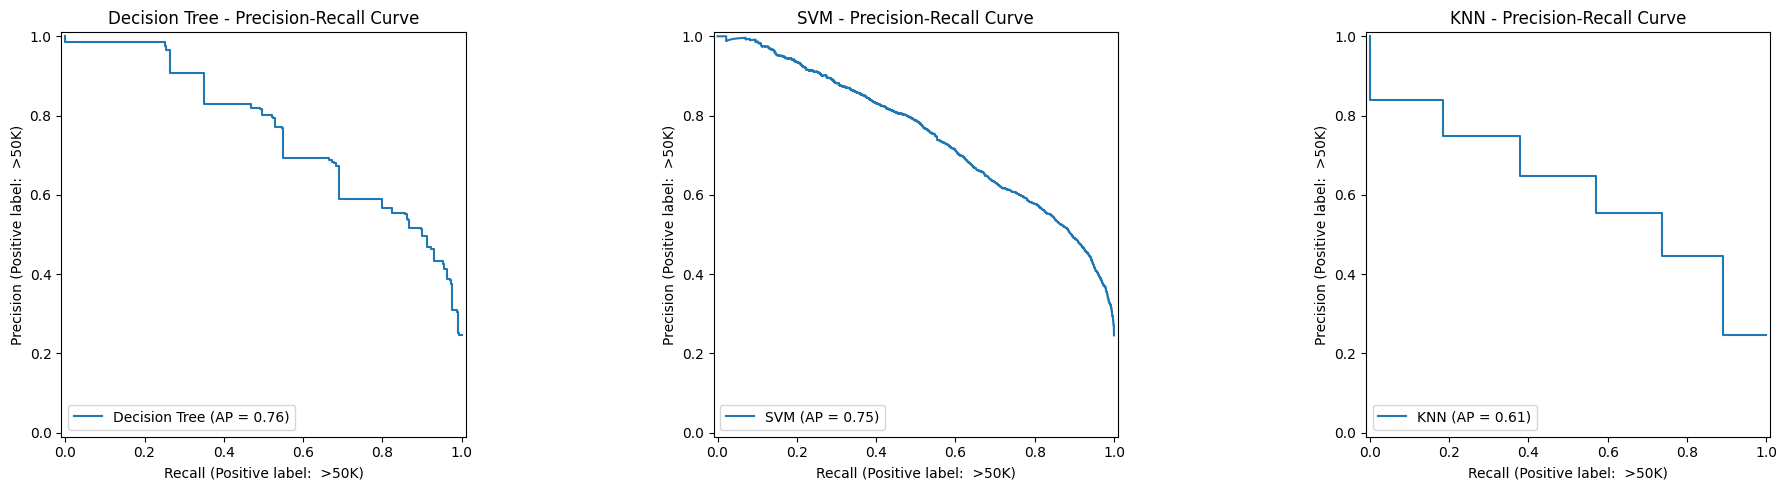

Model Accuracies:
Decision Tree Accuracy: 0.85
SVM Accuracy: 0.84
KNN Accuracy: 0.82


In [ ]:
# Create subplots for the three models
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Decision Tree
PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, ax=ax[0], name="Decision Tree"
)  # Replace 'model' with your Decision Tree model variable
ax[0].set_title("Decision Tree - Precision-Recall Curve")

# SVM
PrecisionRecallDisplay.from_estimator(
    svm_best, X_test, y_test, ax=ax[1], name="SVM"
)
ax[1].set_title("SVM - Precision-Recall Curve")

# KNN
PrecisionRecallDisplay.from_estimator(
    knn_best, X_test, y_test, ax=ax[2], name="KNN"
)
ax[2].set_title("KNN - Precision-Recall Curve")

# Adjust layout
plt.tight_layout()
plt.show()

# Calculate and print accuracy for all models
print("Model Accuracies:")
dt_accuracy = accuracy_score(y_test, model.predict(X_test))  # Replace 'model' with Decision Tree variable
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

svm_accuracy = accuracy_score(y_test, svm_best.predict(X_test))
print(f"SVM Accuracy: {svm_accuracy:.2f}")

knn_accuracy = accuracy_score(y_test, knn_best.predict(X_test))
print(f"KNN Accuracy: {knn_accuracy:.2f}")